## Experiments with of a diffused censored GP in BayesNewton - Fake data 3

### Required imports

In [1]:
import bayesnewton
import numpy as np
import matplotlib.pyplot as plt
import time
import objax
import jax.numpy as jnp
import math
from tqdm import tqdm
from sklearn.metrics import r2_score
from censored_diffused_GP import *
plt.rcParams.update({'font.size': 16})

LOG2PI = math.log(2 * math.pi)
INV2PI = (2 * math.pi) ** -1

### GP hyper-params

In [2]:
var_f = 1.0         # GP variance
len_f = 10.0        # GP lengthscale
lik_variance = 0.1  # Variance of the likelihood

### Create dataset

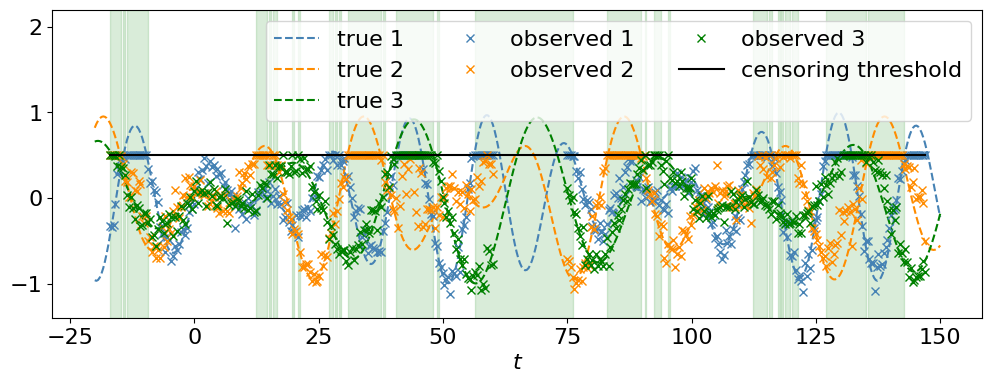

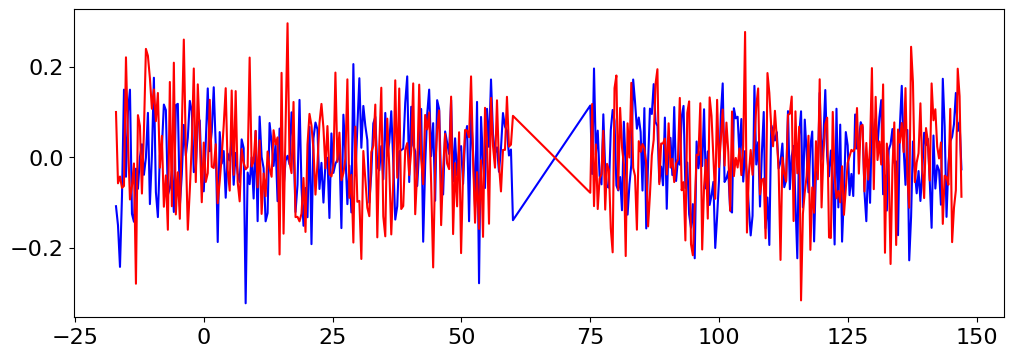

In [3]:
def wiggly_time_series_1(x_):
    return np.cos(0.04*x_+0.33*np.pi) * np.sin(0.4*x_)

def wiggly_time_series_2(x_):
    x_ = x_.copy() - 50
    return np.cos(0.06*x_+0.4*np.pi) * np.sin(0.3*x_)
    #return 2 * wiggly_time_series_1(x_)
    #return wiggly_time_series_1(x_)

def wiggly_time_series_3(x_):
    return np.cos(0.03*x_+0.45*np.pi) * np.sin(0.25*x_)
    #return 2 * wiggly_time_series_1(x_)
    #return wiggly_time_series_1(x_)
    

np.random.seed(123)
N = 200
# x = np.linspace(-17, 147, num=N)
x = np.concatenate([
    np.linspace(-17, 60, num=N),
    np.linspace(75, 147, num=N)
    ], axis=0)
f1 = wiggly_time_series_1(x)[:, None]
f2 = wiggly_time_series_2(x)[:, None]
f3 = wiggly_time_series_3(x)[:, None]
f = np.concatenate([f1, f2, f3], axis=1)[..., None]

#noise_cov = np.array([[0.2, 0.1], [0.1, 0.3]])
#noise_cov = np.array([[0.1, 0.05], [0.05, 0.2]])
noise_cov = np.array([[0.01, 0.0, 0.0], [0.00, 0.01, 0.0], [0.0, 0.0, 0.01]])

noise = np.linalg.cholesky(noise_cov)[None] @ np.random.multivariate_normal(np.zeros(3), np.eye(3), f.shape[0])[..., None]
y = f + noise

censoring_thre = 0.5*np.ones(y.shape)
censoring_indicator = y > censoring_thre
y_cens = np.where(censoring_indicator, censoring_thre, y)
y_excess = y - y_cens
y_diffused = y_cens.copy()
y_diffused[:, 1] += y_excess[:, 0] # 0 sends all to 1
y_diffused[:, 1] += y_excess[:, 2] # 2 sends all to 1
y_diffused[:, 0] += 0.5*y_excess[:, 1] # 1 sends to both 0 and 2
y_diffused[:, 2] += 0.5*y_excess[:, 1] # 1 sends to both 0 and 2

# throw away excess demand even after diffusion
y_diffused = np.minimum(y_diffused, censoring_thre)

#x_test = np.linspace(np.min(x)-0.0, np.max(x)+0.0, num=500)
x_test = np.concatenate([
    np.linspace(-17, 60, num=500),
    np.linspace(75, 147, num=500)
    ], axis=0)
f1_test = wiggly_time_series_1(x_test)[:, None]
f2_test = wiggly_time_series_2(x_test)[:, None]
f3_test = wiggly_time_series_3(x_test)[:, None]
f_test = np.concatenate([f1_test, f2_test, f3_test], axis=1)[..., None]
noise_test = np.linalg.cholesky(noise_cov)[None] @ np.random.multivariate_normal(np.zeros(3), np.eye(3), f_test.shape[0])[..., None]
y_test = f_test + noise_test
x_plot = np.linspace(np.min(x)-3.0, np.max(x)+3.0, 500)
f1_plot = wiggly_time_series_1(x_plot)
f2_plot = wiggly_time_series_2(x_plot)
f3_plot = wiggly_time_series_3(x_plot)


in_censoring = False
censoring_start = x[0]
censoring_ranges = []
for i in range(len(censoring_indicator)):
    if in_censoring:
        if not np.any(censoring_indicator[i]):
            censoring_ranges.append([censoring_start, x[i]])
            in_censoring = False
    else:
        if np.any(censoring_indicator[i]):
            censoring_start = x[i]
            in_censoring = True

plt.figure(1, figsize=(12, 4))


plt.plot(x_plot, f1_plot, '--', color='steelblue', label='true 1')
plt.plot(x_plot, f2_plot, '--', color='darkorange', label='true 2')
plt.plot(x_plot, f3_plot, '--', color='green', label='true 3')
plt.plot(x, y_diffused[:, 0], 'x', color='steelblue', label='observed 1')
plt.plot(x, y_diffused[:, 1], 'x', color='darkorange', label='observed 2')
plt.plot(x, y_diffused[:, 2], 'x', color='green', label='observed 3')
plt.plot(x, censoring_thre[:,0], 'k-', label='censoring threshold')
for pair in censoring_ranges:
    plt.axvspan(pair[0], pair[1], alpha=0.15, color='green')
plt.legend(loc="upper right", ncol=3)
plt.ylim([-1.4, 2.2])
plt.xlabel('$t$')
#plt.ylabel('demand')
plt.savefig('fake_dataC.pdf', format='pdf')
plt.show()

plt.figure(2, figsize=(12, 4))
plt.plot(x, noise[:, 0], 'b')
plt.plot(x, noise[:, 1], 'r')
plt.show()

# BLUE sends to RED; GREEN sends to RED; RED sends to both

In [4]:
# 0 sends all to 1; 2 sends all to 1; 1 sends to both 0 and 2
X_diffusion = jnp.array([[-1,-1],
                         [0,0],
                         [1,1]])

print("----------------------- Regularized Laplacian kernel:")
print(k_RL(X_diffusion, lengthscale=10, beta=1))

print("----------------------- Diffusion kernel:")
print(k_Diff(X_diffusion, lengthscale=10, beta=1))

print("----------------------- My diffusion kernel:")
print(compute_transition_matrix(X_diffusion, diffusion_lengthscale=10))

----------------------- Regularized Laplacian kernel:
W: [[1.         0.98019867 0.92311635]
 [0.98019867 1.         0.98019867]
 [0.92311635 0.98019867 1.        ]]
Lap: [[ 1.90331502 -0.98019867 -0.92311635]
 [-0.98019867  1.96039735 -0.98019867]
 [-0.92311635 -0.98019867  1.90331502]]
[[0.50629818 0.24874376 0.24495806]
 [0.24874376 0.50251248 0.24874376]
 [0.24495806 0.24874376 0.50629818]]
----------------------- Diffusion kernel:
W: [[1.         0.98019867 0.92311635]
 [0.98019867 1.         0.98019867]
 [0.92311635 0.98019867 1.        ]]
Lap: [[ 1.90331502 -0.98019867 -0.92311635]
 [-0.98019867  1.96039735 -0.98019867]
 [-0.92311635 -0.98019867  1.90331502]]
[[0.14907362 2.66498565 2.51712241]
 [2.66498565 0.14080246 2.66498565]
 [2.51712241 2.66498565 0.14907362]]
----------------------- My diffusion kernel:
[[0.         0.50749944 0.49250056]
 [0.5        0.         0.5       ]
 [0.49250056 0.50749944 0.        ]]


censoring_threshold: (400, 3) 
 [[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]]
f_pred: (400, 3) 
 [[-0.57156965  0.9817748   0.58202266]
 [-0.48056148  0.77635455  0.68185761]
 [-0.43318234  0.73271109  0.60233899]
 [-0.13493641  0.63940982  0.42188742]
 [ 0.2424244   0.56664926  0.33971834]]
excess_demand: (400, 3) 
 [[0.         0.4817748  0.08202266]
 [0.         0.27635455 0.18185761]
 [0.         0.23271109 0.10233899]
 [0.         0.13940982 0.        ]
 [0.         0.06664926 0.        ]]
diffused_f: (400, 3) 
 [[-0.29028605  1.02340125  0.82291006]
 [-0.25281923  0.86864718  0.82003489]
 [-0.26642479  0.78464807  0.71869454]
 [-0.0652315   0.63940982  0.49159233]
 [ 0.27574904  0.56664926  0.37304297]]


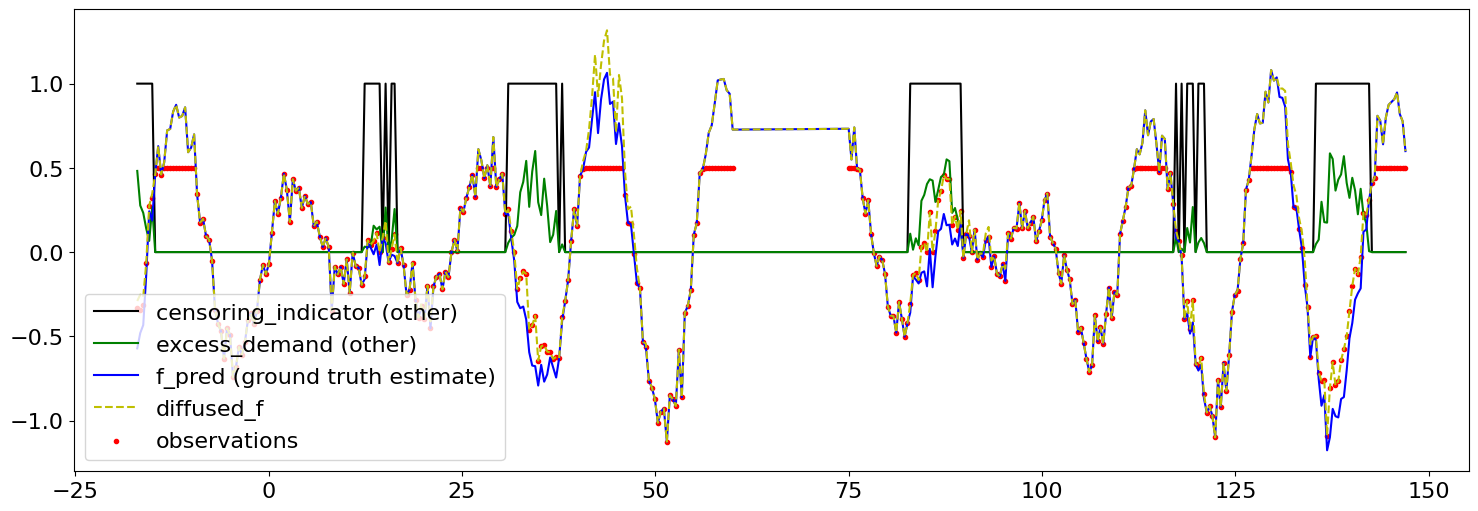

In [5]:
### Testing out the diffusion process to see if it is working

transition_matrix = compute_transition_matrix(X_diffusion, diffusion_lengthscale=10)

### Diffuse excess demand based on transition matrix define above for k diffusion steps
censoring_threshold = censoring_thre[:,:,0]
print("censoring_threshold:", censoring_threshold.shape, '\n', censoring_threshold[:5])
f_pred = y[:,:,0] ## assume perfect estimate for f_pred
print("f_pred:", f_pred.shape, '\n', f_pred[:5])
excess_demand = jnp.maximum(f_pred - censoring_threshold, jnp.zeros(f_pred.shape))
print("excess_demand:", excess_demand.shape, '\n', excess_demand[:5])
diffused_f = f_pred + excess_demand @ transition_matrix
print("diffused_f:", diffused_f.shape, '\n', diffused_f[:5])
plt.figure(figsize=(18,6))
plt.plot(x, censoring_indicator[:,1], 'k-')
plt.plot(x, excess_demand[:,1], 'g-')
plt.plot(x, f_pred[:,0], 'b-')
plt.plot(x, diffused_f[:,0], 'y--')
plt.scatter(x, y_diffused[:,0,0], marker='.', c='r')
plt.legend(["censoring_indicator (other)", 
            "excess_demand (other)", 
            "f_pred (ground truth estimate)", 
            "diffused_f",
            "observations"])
plt.show()

### Re-usable code blocks for training and evaluating models

In [6]:
def train_model(kern, lik, x, y, iters=300, lr_adam=0.1, lr_newton=0.1):
    # model = bayesnewton.models.MarkovNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # model = bayesnewton.models.MarkovExpectationPropagationGP(kernel=kern, likelihood=lik, X=x, Y=y, power=0.5)
    # -- Gauss-Newton ---
    # model = bayesnewton.models.MarkovGaussNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # model = bayesnewton.models.MarkovVariationalGaussNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # -- quasi-Newton ---
    # model = bayesnewton.models.MarkovQuasiNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # model = bayesnewton.models.MarkovVariationalQuasiNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y)
    # model = bayesnewton.models.MarkovExpectationPropagationQuasiNewtonGP(kernel=kern, likelihood=lik, X=x, Y=y, power=0.5)
    # --- Riemannian grads ---
    # model = bayesnewton.models.MarkovVariationalRiemannGP(kernel=kern, likelihood=lik, X=x, Y=y)

    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())


    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op():
        model.inference(lr=lr_newton)  # perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(lr_adam, dE)
        return E


    train_op = objax.Jit(train_op)

    t0 = time.time()
    loop = tqdm(range(iters))
    losses = []
    for i in loop:
        loss = train_op()
        #if not i % 20:
        #    print('iter %2d, energy: %1.4f' % (i, loss[0]))
        loop.set_description(f"Iter [{i}/{iters}]")
        loop.set_postfix(loss=loss[0])
        losses.append(loss[0])
    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    
    plt.figure(1, figsize=(6, 4))
    plt.plot(losses, label='training loss')
    plt.title("Training loss")
    plt.show()
    
    return model
    

def eval_model(model, x, y, y_diffused, x_test, y_test):
    t0 = time.time()
    # evaluate on train set 
    posterior_mean_train, posterior_cov_train = model.predict_y(X=x)
    nlpd_train_diff = model.negative_log_predictive_density(X=x, extra=None, Y=y_diffused)
    nlpd_train = model.negative_log_predictive_density(X=x, extra=None, Y=y)
    rmse_train = np.sqrt(np.mean((y[:,:posterior_mean_train.shape[1],0] - posterior_mean_train)**2))
    r2_train = r2_score(y[:,:posterior_mean_train.shape[1],0], np.array(posterior_mean_train)) 
    rmse_f = np.sqrt(np.mean((f[:,:posterior_mean_train.shape[1],0] - posterior_mean_train)**2))
    print('[trainset] nlpd (diff): %2.3f\tnlpd (true): %2.3f\trmse (true): %2.3f\tr2 (true): %2.3f\trmse (func): %2.3f' % (nlpd_train_diff, nlpd_train, rmse_train, r2_train, rmse_f))
    
    # evaluate on test set 
    posterior_mean_test, posterior_cov_test = model.predict_y(X=x_test)
    nlpd_test = model.negative_log_predictive_density(X=x_test, Y=y_test)
    rmse_test = np.sqrt(np.mean((y_test[:,:posterior_mean_test.shape[1],0] - posterior_mean_test)**2))
    r2_test = r2_score(y_test[:,:posterior_mean_test.shape[1],0], np.array(posterior_mean_test))
    rmse_fplot = np.sqrt(np.mean((f_test[:,:posterior_mean_test.shape[1],0] - posterior_mean_test)**2))
    print('[testset] \t\t\tnlpd (true): %2.3f\trmse (true): %2.3f\tr2 (true): %2.3f\trmse (func): %2.3f' % (nlpd_test, rmse_test, r2_test, rmse_fplot))
    t1 = time.time()
    print('prediction time: %2.2f secs' % (t1-t0))

    # make plots with predictions
    posterior_mean, posterior_cov = model.predict_y(X=x_plot)
    posterior_var = bayesnewton.utils.diag(posterior_cov)
    lb = posterior_mean - 1.96 * posterior_var ** 0.5
    ub = posterior_mean + 1.96 * posterior_var ** 0.5
    
    print('plotting ...')
    plt.figure(1, figsize=(12, 4))
    plt.clf()
    plt.plot(x, y_diffused[:, 0], 'bx', label='observed 1')
    plt.plot(x, y_diffused[:, 1], 'rx', label='observed 2')
    plt.plot(x, y_diffused[:, 2], 'gx', label='observed 3')
    for pair in censoring_ranges:
        plt.axvspan(pair[0], pair[1], alpha=0.15, color='yellow')
    # plt.plot(x_test, y_test, 'r.', alpha=0.4, label='test observations')
    plt.plot(x_plot, posterior_mean[:, 0], 'b', label='inferred 1')
    plt.plot(x_plot, posterior_mean[:, 1], 'r', label='inferred 2')
    plt.plot(x_plot, posterior_mean[:, 2], 'g', label='inferred 3')
    plt.plot(x_plot, f1_plot, 'b--', label='true 1')
    plt.plot(x_plot, f2_plot, 'r--', label='true 2')
    plt.plot(x_plot, f3_plot, 'g--', label='true 3')
    plt.fill_between(x_plot, lb[:, 0], ub[:, 0], color='b', alpha=0.05)
    plt.fill_between(x_plot, lb[:, 1], ub[:, 1], color='r', alpha=0.05)
    plt.fill_between(x_plot, lb[:, 2], ub[:, 2], color='g', alpha=0.05)
    plt.xlim([x_plot[0], x_plot[-1]])
    if hasattr(model, 'Z'):
        plt.plot(model.Z.value[:, 0], -2 * np.ones_like(model.Z.value[:, 0]), 'b^', markersize=5)
    #plt.legend()
    plt.legend(loc="upper right", ncol=3)
    plt.ylim([-1.4, 2.2])
    plt.xlabel('$t$')
    #plt.ylabel('demand')
    plt.show()

### Fit Gaussian GP to true data

Iter [299/300]: 100%|██████████| 300/300 [00:26<00:00, 11.47it/s, loss=-755.7392879252083]


optimisation time: 26.16 secs


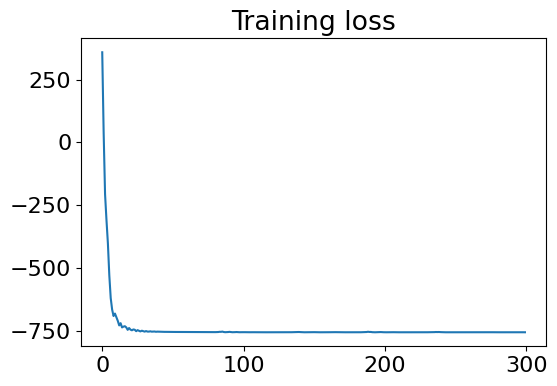

In [7]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern3 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2, kern3])
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyGaussianMulti(ndim=3, variance=lik_variance*jnp.ones(3))
#lik = bayesnewton.likelihoods.Gaussian(variance=1)

model = train_model(kern, lik, x, y)

[trainset] nlpd (diff): 0.472	nlpd (true): -2.871	rmse (true): 0.092	r2 (true): 0.964	rmse (func): 0.032
[testset] 			nlpd (true): -2.527	rmse (true): 0.104	r2 (true): 0.954	rmse (func): 0.031
prediction time: 5.11 secs
plotting ...


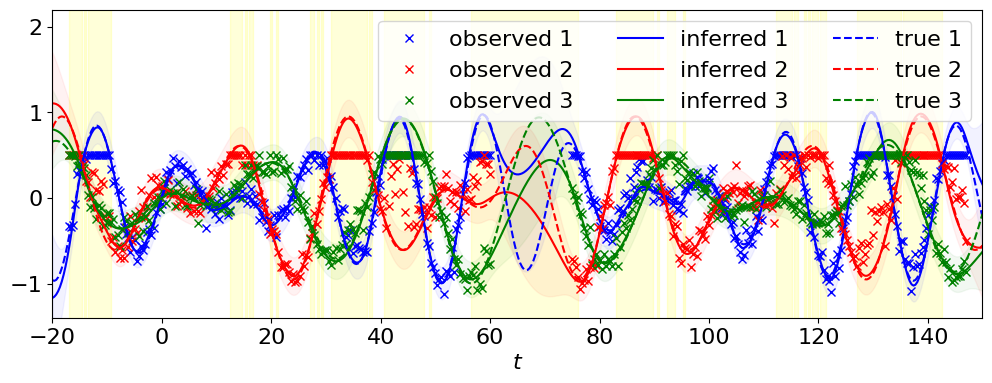

In [8]:
eval_model(model, x, y, y_diffused, x_test, y_test)

### Fit Gaussian GP to diffused data

Iter [299/300]: 100%|██████████| 300/300 [00:26<00:00, 11.45it/s, loss=-780.151205918914] 


optimisation time: 26.20 secs


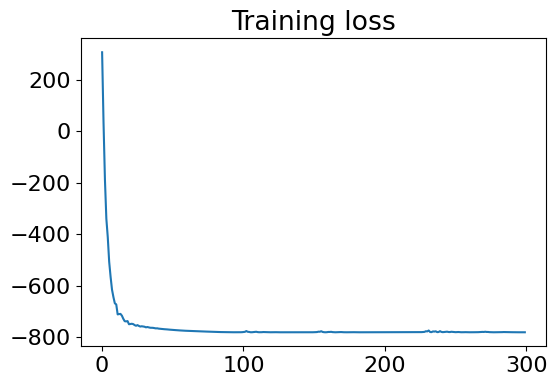

In [9]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern3 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2, kern3])
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyGaussianMulti(ndim=3, variance=lik_variance*jnp.ones(3))
#lik = bayesnewton.likelihoods.Gaussian(variance=1)

model = train_model(kern, lik, x, y_diffused)

[trainset] nlpd (diff): -3.026	nlpd (true): 0.545	rmse (true): 0.184	r2 (true): 0.864	rmse (func): 0.162
[testset] 			nlpd (true): 0.805	rmse (true): 0.188	r2 (true): 0.856	rmse (func): 0.162
prediction time: 2.97 secs
plotting ...


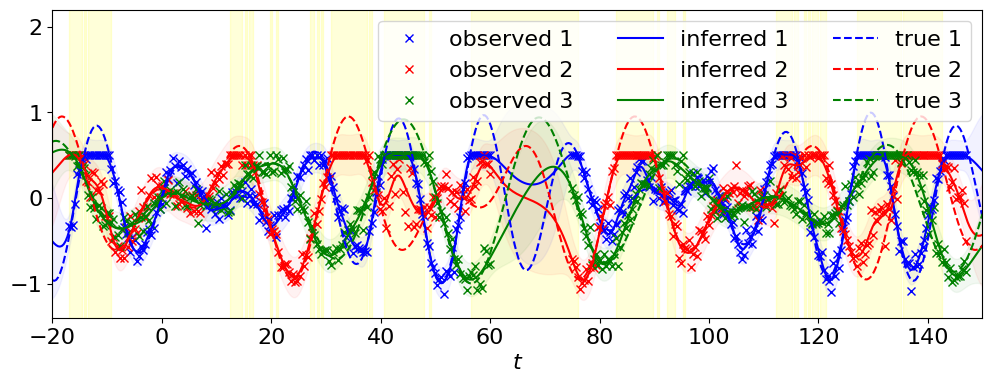

In [10]:
eval_model(model, x, y, y_diffused, x_test, y_test)

### Fit Censored Gaussian GP to diffused data

Iter [299/300]: 100%|██████████| 300/300 [01:18<00:00,  3.84it/s, loss=-481.5177470110432] 

optimisation time: 78.10 secs


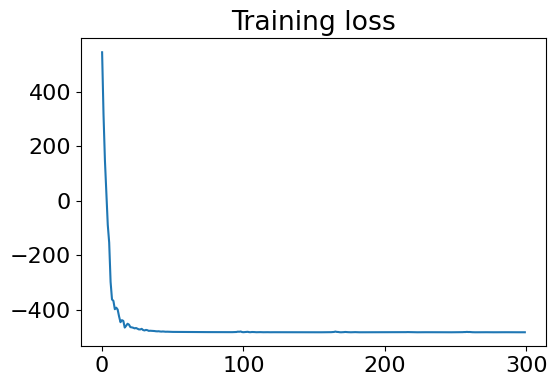

In [11]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern3 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2, kern3])
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyCensoredGaussianMulti(ndim=3, variance=lik_variance*jnp.ones(3))
#lik = bayesnewton.likelihoods.Gaussian(variance=1)

model = train_model(kern, lik, x, np.concatenate([y_diffused, censoring_thre], axis=1), lr_adam=0.1, lr_newton=0.1)

[trainset] nlpd (diff): -2.131	nlpd (true): -1.527	rmse (true): 0.148	r2 (true): 0.912	rmse (func): 0.123
[testset] 			nlpd (true): -1.224	rmse (true): 0.157	r2 (true): 0.900	rmse (func): 0.122
prediction time: 4.56 secs
plotting ...


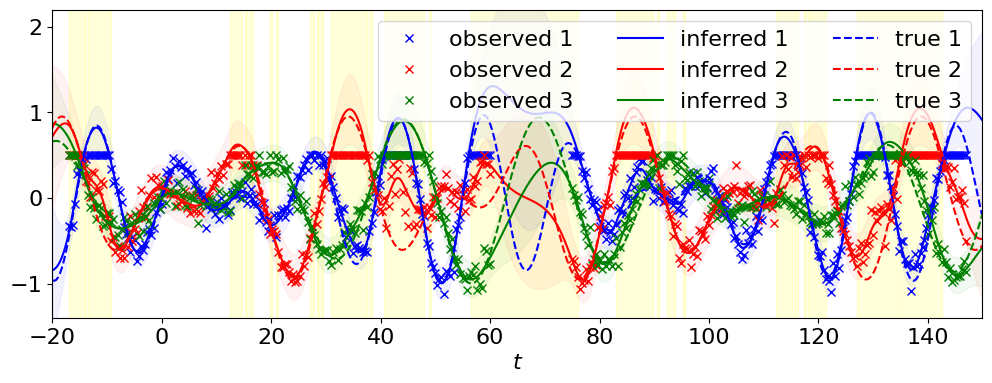

In [12]:
eval_model(model, 
           x, np.concatenate([y, censoring_thre], axis=1), np.concatenate([y_diffused, censoring_thre], axis=1),
           x_test, np.concatenate([y_test, censoring_thre[0,0]*jnp.ones(y_test.shape)], axis=1))

### Fit Diffused Censored Gaussian GP to diffused data - D

Iter [299/300]: 100%|██████████| 300/300 [09:59<00:00,  2.00s/it, loss=-475.95673265585197]


optimisation time: 599.36 secs


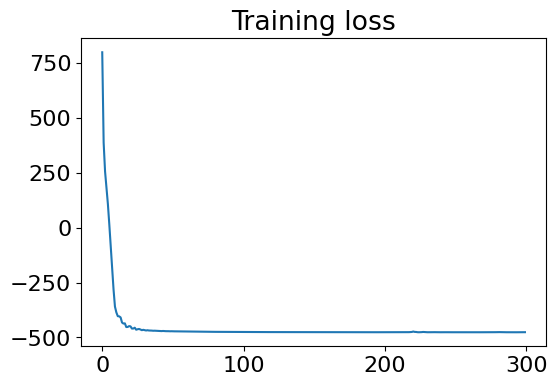

In [7]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern3 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2, kern3])
#lik = bayesnewton.likelihoods.Gaussian(variance=1)
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyDiffusedCensoredGaussianMultiD(X_diffusion, 
                                      ndim=3, 
                                      variance=lik_variance*jnp.ones(3),
                                      diffusion_lengthscale=1.,
                                      diffusion_variance=1.,
                                      fix_diffusion=True,
                                      fix_variance=False)

model = train_model(kern, lik, x, np.concatenate([y_diffused, censoring_thre], axis=1), lr_adam=0.1, lr_newton=0.1)

[trainset] nlpd (diff): -2.115	nlpd (true): -1.533	rmse (true): 0.099	r2 (true): 0.959	rmse (func): 0.043
[testset] 			nlpd (true): -1.311	rmse (true): 0.107	r2 (true): 0.952	rmse (func): 0.042
prediction time: 7.35 secs
plotting ...


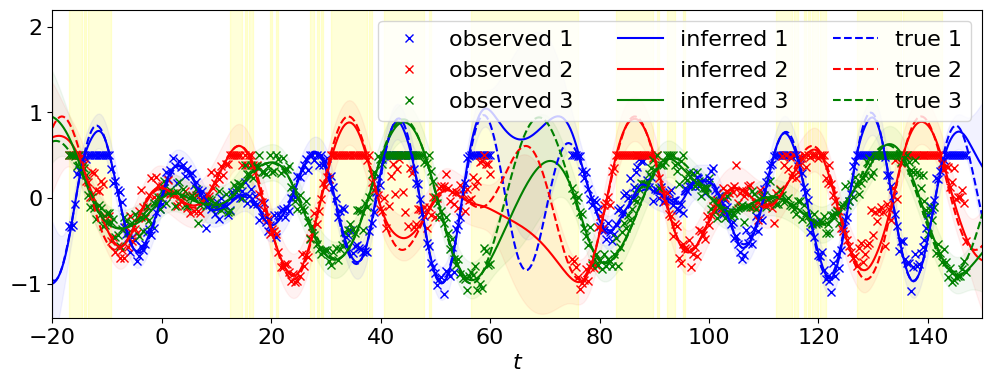

In [10]:
eval_model(model, 
           x, np.concatenate([y, censoring_thre], axis=1), np.concatenate([y_diffused, censoring_thre], axis=1), 
           x_test, np.concatenate([y_test, censoring_thre[0,0]*jnp.ones(y_test.shape)], axis=1))

Iter [299/300]: 100%|██████████| 300/300 [09:31<00:00,  1.90s/it, loss=-481.6096811624672] 


optimisation time: 571.05 secs


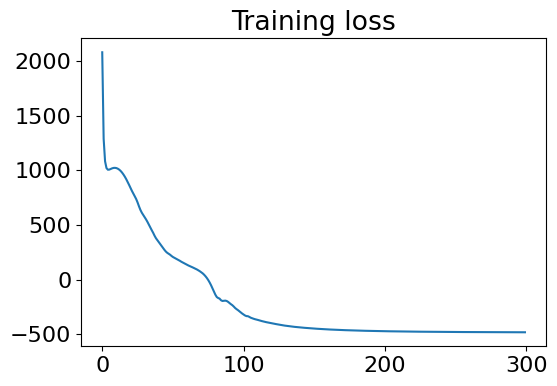

In [9]:
kern1 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern2 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern3 = bayesnewton.kernels.Matern52(variance=var_f, lengthscale=len_f)
kern = bayesnewton.kernels.Independent(kernels=[kern1, kern2, kern3])
#lik = bayesnewton.likelihoods.Gaussian(variance=1)
#lik = bayesnewton.likelihoods.GaussianMultivariate(covariance=noise_cov)
lik = MyDiffusedCensoredGaussianMultiD(X_diffusion, 
                                      ndim=3, 
                                      variance=lik_variance*jnp.ones(3),
                                      diffusion_lengthscale=1.,
                                      diffusion_variance=1.,
                                      fix_diffusion=False,
                                      fix_variance=False)

model = train_model(kern, lik, x, np.concatenate([y_diffused, censoring_thre], axis=1), lr_adam=0.1, lr_newton=0.01)

[trainset] nlpd (diff): -2.092	nlpd (true): -1.609	rmse (true): 0.122	r2 (true): 0.940	rmse (func): 0.086
[testset] 			nlpd (true): -1.380	rmse (true): 0.130	r2 (true): 0.930	rmse (func): 0.086
prediction time: 5.25 secs
plotting ...


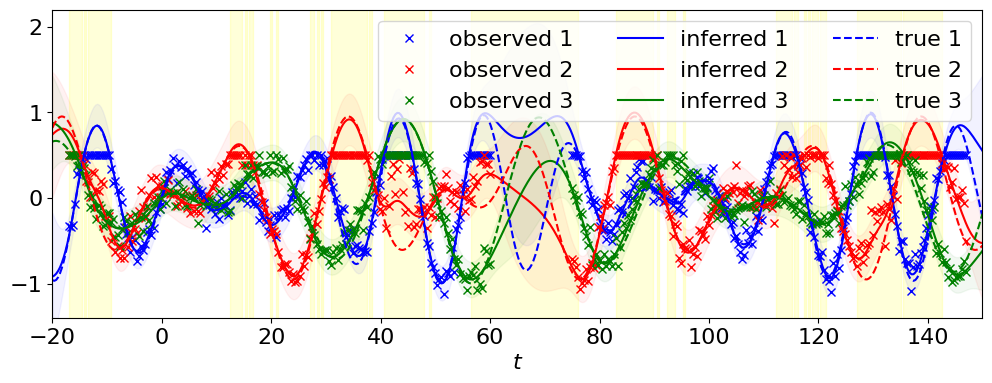

In [13]:
eval_model(model, 
           x, np.concatenate([y, censoring_thre], axis=1), np.concatenate([y_diffused, censoring_thre], axis=1), 
           x_test, np.concatenate([y_test, censoring_thre[0,0]*jnp.ones(y_test.shape)], axis=1))